In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import os

In [99]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
#This tells PIL to load what it can, even from truncated images, rather than throwing an error

In [36]:
#create folders for train and test pictures
base_dir = './data/weather_pics/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [37]:
train_dir

'./data/weather_pics/train'

In [38]:
filenames = os.listdir('./data/weather_pics/')

In [39]:
len(filenames)

1102

#### Make the target species list

In [40]:
filenames[:5]

['cloudy126.jpg', 'rain20.jpg', 'rain34.jpg', 'cloudy132.jpg', 'sunrise33.jpg']

In [41]:
from collections import Counter
counter = Counter([s[:4] for s in filenames])

In [42]:
counter

Counter({'sunr': 349, 'clou': 294, 'shin': 248, 'rain': 210, '.DS_': 1})

In [43]:
species = list(counter.keys()) 

In [44]:
species

['clou', 'rain', 'sunr', 'shin', '.DS_']

#### Separate data by train/test and targets

In [45]:
train_dir

'./data/weather_pics/train'

In [46]:
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

In [47]:
for train_or_test in ['train', 'test']:
    for spec in species:
        path = os.path.join(base_dir, train_or_test, spec)
        os.mkdir(path)
        print(path)

./data/weather_pics/train/clou
./data/weather_pics/train/rain
./data/weather_pics/train/sunr
./data/weather_pics/train/shin
./data/weather_pics/train/.DS_
./data/weather_pics/test/clou
./data/weather_pics/test/rain
./data/weather_pics/test/sunr
./data/weather_pics/test/shin
./data/weather_pics/test/.DS_


In [48]:
import shutil

In [49]:
for i, img in enumerate(filenames):
    for spec in species:
        if spec in img:
            imag_path = os.path.join(base_dir, img)
            if i%5 == 0:
                path = os.path.join(base_dir, 'test', spec, img)
            else:
                path = os.path.join(base_dir, 'train', spec, img)
            shutil.copy(imag_path, path)

In [50]:
for train_or_test in ['train', 'test']:
    for spec in species:
        print(train_or_test, spec, len(os.listdir(os.path.join(base_dir, train_or_test, spec))))
print

train clou 232
train rain 167
train sunr 286
train shin 195
train .DS_ 1
test clou 62
test rain 43
test sunr 63
test shin 53
test .DS_ 0


<function print>

## Preprocess images

In [51]:
from torchvision import transforms

In [52]:
transform = transforms.Compose([
    transforms.Resize((96,96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [53]:
train_dir

'./data/weather_pics/train'

 `torchvision.datasets.ImageFolder ` will:
- Walk through all subfolders inside train_dir.
- Treat each folder name as a class label.
- Associate every image file inside a folder with that folder’s label.

In [54]:
from torchvision.datasets import ImageFolder

In [102]:
import os

def clean_classes(folder):
    for item in os.listdir(folder):
        full_path = os.path.join(folder, item)
        if not os.path.isdir(full_path) or item.startswith('.'):
            try:
                if os.path.isfile(full_path):
                    os.remove(full_path)
                else:
                    shutil.rmtree(full_path)
            except Exception as e:
                print(f"Could not remove {full_path}: {e}")

clean_classes(train_dir)
clean_classes(test_dir)

In [103]:
train_ds = torchvision.datasets.ImageFolder(train_dir, transform = transform)
test_ds = torchvision.datasets.ImageFolder(test_dir, transform = transform)

In [104]:
train_ds

Dataset ImageFolder
    Number of datapoints: 877
    Root location: ./data/weather_pics/train
    StandardTransform
Transform: Compose(
               Resize(size=(96, 96), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [105]:
len(train_ds)

877

In [106]:
len(test_ds)

221

In [107]:
train_ds.classes

['clou', 'rain', 'shin', 'sunr']

In [108]:
train_ds.class_to_idx

{'clou': 0, 'rain': 1, 'shin': 2, 'sunr': 3}

The output of `torchvision.datasets.ImageFolder` is actually an instance of a custom Dataset class, specifically `torchvision.datasets.folder.ImageFolder`, which inherits from `torch.utils.data.Dataset`. You can directly convert it to DataLoader for following ML practices.  

**Therefore to prepare data, especailly image data for Pytorch, simply put pictures in their repective class folders and name the folder the class.**

In [109]:
batch_size = 32

In [110]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = batch_size*2)

In [111]:
imgs, lables = next(iter(train_dl))

In [112]:
imgs.shape

torch.Size([32, 3, 96, 96])

In [113]:
lables.shape

torch.Size([32])

#### Check one image for preview

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78039217..0.8509804].


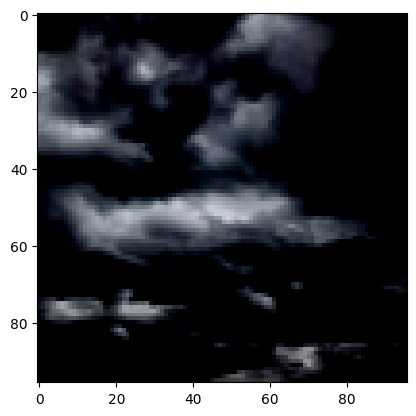

In [114]:
plt.imshow(imgs[2].permute(1,2,0))

Because the pictures are normalized, lots of dark details are below 1. To see the pictures vividly, we can do a simply conversion.

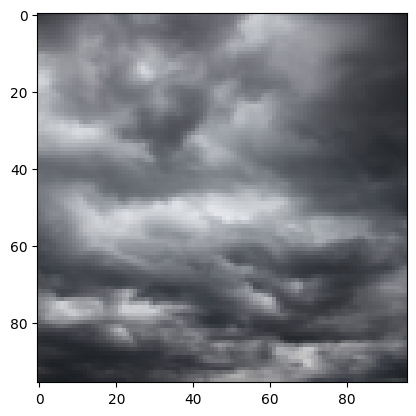

In [115]:
img_test = (imgs[2] + 1)/2
plt.imshow(img_test.permute(1,2,0))

### Batch normalization
$$x' = \beta + \gamma\frac{x-\mu}{\sigma} $$
$\beta$ and $\gamma$ are parameters that need to be learnt via back propagation.

In [116]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3) #16, 94, 94
        #batch normalization
        self.bn1 = nn.BatchNorm2d(16) #16 channles
        self.pool = nn.MaxPool2d(2,2) # 16, 47, 47
        self.conv2 = nn.Conv2d(16, 32, 3) #32, 45, 45
        self.bn2 = nn.BatchNorm2d(32) #32 channles
        #another layer of pooling 32, 22, 22
        self.conv3 = nn.Conv2d(32, 64, 3) # 64, 20, 20
        self.bn3 = nn.BatchNorm2d(64) #64 channles
        #another layer of pooling 64, 10, 10
        
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64*10*10, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024) #1024 channles
        self.fc2 = nn.Linear(1024, 256)
        self.bn_fc2 = nn.BatchNorm1d(256) #2564 channles
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn3(x)

        x = nn.Flatten()(x)
        # x = x.view(-1, 64*10*10)
        x = F.relu(self.fc1(x))
        x = self.bn_fc1(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.bn_fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [117]:
model = Net()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6400, out_features=1024, bias=True)
  (bn_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (bn_fc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [118]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

In [119]:
def fit (epoch, model, train_loader, test_loader):
    correct = 0
    total = 0
    running_loss = 0

    for x, y in train_loader:
        #put the data to GPU
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim = 1)
            correct += (y_pred==y).sum().item()
            total += y.size(0)
            running_loss +=loss.item()
            
    epoch_loss = running_loss/len(train_loader.dataset)
    epoch_acc = correct/total
    
    #test
    test_correct = 0
    test_running_loss = 0
    test_total = 0

    with torch.no_grad():
        for x, y in test_loader:
            #put the data to GPU
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim = 1)
            test_correct += (y_pred==y).sum().item()
            test_total += y.size(0)
            test_running_loss +=loss.item()
    
    test_epoch_loss = test_running_loss/len(test_loader.dataset)
    test_epoch_acc = test_correct/test_total

    print(f'Epoch: {epoch}, loss:{round(epoch_loss, 3)}, accuracy: {round(epoch_acc, 3)}, test_loss: {round(test_epoch_loss, 3)}, test_accuracy: {round(test_epoch_acc, 3)}')
    
    return  epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc  
                

In [120]:
epochs = 20
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

Epoch: 0, loss:0.02, accuracy: 0.741, test_loss: 0.044, test_accuracy: 0.416
Epoch: 1, loss:0.012, accuracy: 0.863, test_loss: 0.05, test_accuracy: 0.439
Epoch: 2, loss:0.009, accuracy: 0.909, test_loss: 0.051, test_accuracy: 0.462
Epoch: 3, loss:0.007, accuracy: 0.916, test_loss: 0.047, test_accuracy: 0.484
Epoch: 4, loss:0.005, accuracy: 0.954, test_loss: 0.05, test_accuracy: 0.498
Epoch: 5, loss:0.005, accuracy: 0.946, test_loss: 0.053, test_accuracy: 0.48
Epoch: 6, loss:0.005, accuracy: 0.943, test_loss: 0.051, test_accuracy: 0.462
Epoch: 7, loss:0.004, accuracy: 0.952, test_loss: 0.055, test_accuracy: 0.466
Epoch: 8, loss:0.003, accuracy: 0.97, test_loss: 0.051, test_accuracy: 0.493
Epoch: 9, loss:0.003, accuracy: 0.977, test_loss: 0.055, test_accuracy: 0.498
Epoch: 10, loss:0.004, accuracy: 0.95, test_loss: 0.059, test_accuracy: 0.502
Epoch: 11, loss:0.003, accuracy: 0.968, test_loss: 0.06, test_accuracy: 0.502
Epoch: 12, loss:0.003, accuracy: 0.966, test_loss: 0.059, test_accura

## Save the model's parameters

In [121]:
list(model.state_dict())

['conv1.weight',
 'conv1.bias',
 'bn1.weight',
 'bn1.bias',
 'bn1.running_mean',
 'bn1.running_var',
 'bn1.num_batches_tracked',
 'conv2.weight',
 'conv2.bias',
 'bn2.weight',
 'bn2.bias',
 'bn2.running_mean',
 'bn2.running_var',
 'bn2.num_batches_tracked',
 'conv3.weight',
 'conv3.bias',
 'bn3.weight',
 'bn3.bias',
 'bn3.running_mean',
 'bn3.running_var',
 'bn3.num_batches_tracked',
 'fc1.weight',
 'fc1.bias',
 'bn_fc1.weight',
 'bn_fc1.bias',
 'bn_fc1.running_mean',
 'bn_fc1.running_var',
 'bn_fc1.num_batches_tracked',
 'fc2.weight',
 'fc2.bias',
 'bn_fc2.weight',
 'bn_fc2.bias',
 'bn_fc2.running_mean',
 'bn_fc2.running_var',
 'bn_fc2.num_batches_tracked',
 'fc3.weight',
 'fc3.bias']

In [122]:
path = './weather_model.pth'
torch.save(model.state_dict(), path)

### Load the saved parameters

In [125]:
new_model = Net()
new_model.load_state_dict(torch.load('./weather_model.pth'))
new_model.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6400, out_features=1024, bias=True)
  (bn_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (bn_fc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

Test the newly loaded model

In [135]:
test_correct = 0
test_running_loss = 0
test_total = 0
new_model.eval()

with torch.no_grad():
    for x, y in test_dl:
        #put the data to GPU
        x, y = x.to(device), y.to(device)
        y_pred = new_model(x)
        loss = loss_fn(y_pred, y)
        y_pred = torch.argmax(y_pred, dim = 1)
        test_correct += (y_pred==y).sum().item()
        test_total += y.size(0)
        test_running_loss +=loss.item()

test_epoch_loss = test_running_loss/len(test_dl.dataset)
test_epoch_acc = test_correct/test_total

print(f'loss:{round(epoch_loss, 3)}, accuracy: {round(epoch_acc, 3)}, test_loss: {round(test_epoch_loss, 3)}, test_accuracy: {round(test_epoch_acc, 3)}')


loss:0.003, accuracy: 0.969, test_loss: 0.005, test_accuracy: 0.91


In [212]:
test_dl

## Save the best parameters

In [131]:
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [136]:
import copy

In [139]:
#parameters without training
best_model_weight = model.state_dict()

best_acc = 0

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(10):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch, model, train_dl, test_dl)
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

    if epoch_test_acc>best_acc:
        best_acc = epoch_test_acc
        best_model_weight = copy.deepcopy(model.state_dict())
    
        

Epoch: 0, loss:0.011, accuracy: 0.872, test_loss: 0.045, test_accuracy: 0.448
Epoch: 1, loss:0.007, accuracy: 0.925, test_loss: 0.045, test_accuracy: 0.489
Epoch: 2, loss:0.005, accuracy: 0.951, test_loss: 0.049, test_accuracy: 0.484
Epoch: 3, loss:0.006, accuracy: 0.948, test_loss: 0.05, test_accuracy: 0.475
Epoch: 4, loss:0.004, accuracy: 0.959, test_loss: 0.052, test_accuracy: 0.498
Epoch: 5, loss:0.004, accuracy: 0.96, test_loss: 0.051, test_accuracy: 0.498
Epoch: 6, loss:0.003, accuracy: 0.969, test_loss: 0.052, test_accuracy: 0.484
Epoch: 7, loss:0.003, accuracy: 0.974, test_loss: 0.055, test_accuracy: 0.462
Epoch: 8, loss:0.003, accuracy: 0.965, test_loss: 0.057, test_accuracy: 0.507
Epoch: 9, loss:0.003, accuracy: 0.975, test_loss: 0.061, test_accuracy: 0.448


In [140]:
new_model = Net()
new_model.load_state_dict(best_model_weight)
new_model.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6400, out_features=1024, bias=True)
  (bn_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (bn_fc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

## Save and load the full model

In [141]:
torch.save(model, './my_whole_model.pth')

In [145]:
new_model2 = torch.load('./my_whole_model.pth', weights_only=False)

In [146]:
new_model2

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6400, out_features=1024, bias=True)
  (bn_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (bn_fc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

## Save and load the model cross devices

In [147]:
torch.save(model.state_dict(), './my_besst_weight')

In [148]:
model = Net()
model.load_state_dict(torch.load('./my_besst_weight', map_location = device))

<All keys matched successfully>